<h1>Example Kraken Spot Market Client Usage</h1>
(as of python-kraken-sdk v0.7.4 => <a href="https://pypi.org/project/python-kraken-sdk/0.7.4/">https://pypi.org/project/python-kraken-sdk/0.7.4/</a>)

In [1]:
from kraken.spot import Market

In [2]:
#!python3 -m pip install matplotlib numpy pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

____
# Market data Example

### 1. Create the unauthenticated market client

In [3]:
market = Market() 

### 2. Get the OHLC data of the XBTUSD pair, create the dataframe, and set the time index

In [4]:
df = pd.DataFrame(
    market.get_ohlc(pair='XBTUSD', interval=60)['XXBTZUSD'],
    columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count']
).astype(float)
# df = df.set_index('time')
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.sort_values(by='time')
df

,time,open,high,low,close,vwap,volume,count
0,2022-10-30 12:00:00,20777.4,20777.4,20695.0,20743.6,20720.2,18.181759,349.0
1,2022-10-30 13:00:00,20743.6,20743.6,20633.9,20658.8,20687.0,82.791462,649.0
2,2022-10-30 14:00:00,20658.9,20747.5,20650.0,20740.1,20721.9,91.171326,558.0
3,2022-10-30 15:00:00,20744.9,20749.4,20661.0,20684.1,20690.6,109.184200,663.0
4,2022-10-30 16:00:00,20684.1,20689.8,20564.4,20600.2,20636.6,109.117698,717.0
...,...,...,...,...,...,...,...,...
715,2022-11-29 07:00:00,16453.0,16493.2,16452.9,16455.0,16474.4,165.334856,831.0
716,2022-11-29 08:00:00,16455.0,16538.7,16425.1,16493.2,16467.6,62.306396,776.0
717,2022-11-29 09:00:00,16491.7,16514.8,16476.9,16510.2,16491.6,96.290237,625.0
718,2022-11-29 10:00:00,16511.2,16524.7,16487.9,16499.7,16501.5,130.971111,737.0


### 3. Compute some indicatoes based on the loaded data

In [5]:
# compute ema
df['ema21'] = df['close'].ewm(span=21, adjust=False, min_periods=21).mean()
df['ema50'] = df['close'].ewm(span=50, adjust=False, min_periods=50).mean()
df['ema200'] = df['close'].ewm(span=200, adjust=False, min_periods=200).mean()        

In [6]:
def support_and_resistance(df: pd.DataFrame, lookback: int=200, levels: int=3) -> dict:
    ''' Returns up to 3 support and resistance levels by given dataframe '''
    high = df['high'][-lookback:].max()
    low = df['low'][-lookback:].min()
    close = df['close'][-lookback:].iloc[-1]

    pp = (high + low + close) / 3
    s1 = 2 * pp - high
    r1 = 2 * pp - low
    if levels >= 2:
        s2 = pp - (high - low)
        r2 = pp + (high - low)
        if levels >= 3:
            s3 = low - 2 * (high -pp)
            r3 = high + 2 * (pp - low)
            return { 's1': s1, 's2': s2, 's3': s3, 'r1': r1, 'r2': r2, 'r3': r3 }
        return { 's1': s1, 's2': s2, 'r1': r1, 'r2': r2 }
    return { 's1': s1,  'r2': r1 }

In [7]:
# compute support and resistance levels
for i, row in enumerate(df.index):
    try:
        srlevels = support_and_resistance(df.iloc[:i], lookback=50, levels=2)
        df.at[row, 's1'] = srlevels['s1']
        df.at[row, 'r1'] = srlevels['r1']
        df.at[row, 's2'] = srlevels['s2']
        df.at[row, 'r2'] = srlevels['r2']
    except:
        df.at[row, 's1'] = np.NaN
        df.at[row, 'r1'] = np.NaN
        df.at[row, 's2'] = np.NaN
        df.at[row, 'r2'] = np.NaN

# isnt that a beauty?:
df

,time,open,high,low,close,vwap,volume,count,ema21,ema50,ema200,s1,r1,s2,r2
0,2022-10-30 12:00:00,20777.4,20777.4,20695.0,20743.6,20720.2,18.181759,349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-30 13:00:00,20743.6,20743.6,20633.9,20658.8,20687.0,82.791462,649.0,NaN,NaN,NaN,20699.933333,20782.333333,20656.266667,20821.066667
2,2022-10-30 14:00:00,20658.9,20747.5,20650.0,20740.1,20721.9,91.171326,558.0,NaN,NaN,NaN,20602.666667,20746.166667,20546.533333,20833.533333
3,2022-10-30 15:00:00,20744.9,20749.4,20661.0,20684.1,20690.6,109.184200,663.0,NaN,NaN,NaN,20656.866667,20800.366667,20573.633333,20860.633333
4,2022-10-30 16:00:00,20684.1,20689.8,20564.4,20600.2,20636.6,109.117698,717.0,NaN,NaN,NaN,20619.533333,20763.033333,20554.966667,20841.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2022-11-29 07:00:00,16453.0,16493.2,16452.9,16455.0,16474.4,165.334856,831.0,16307.303255,16335.586819,16452.405604,16105.800000,16694.400000,15758.600000,16935.800000
716,2022-11-29 08:00:00,16455.0,16538.7,16425.1,16493.2,16467.6,62.306396,776.0,16324.202959,16341.767728,16452.811519,16107.133333,16695.733333,15759.266667,16936.466667
717,2022-11-29 09:00:00,16491.7,16514.8,16476.9,16510.2,16491.6,96.290237,625.0,16341.111781,16348.372915,16453.382548,16132.600000,16721.200000,15772.000000,16949.200000
718,2022-11-29 10:00:00,16511.2,16524.7,16487.9,16499.7,16501.5,130.971111,737.0,16355.528892,16354.307310,16453.843419,16143.933333,16732.533333,15777.666667,16954.866667


### 4. Plot the results

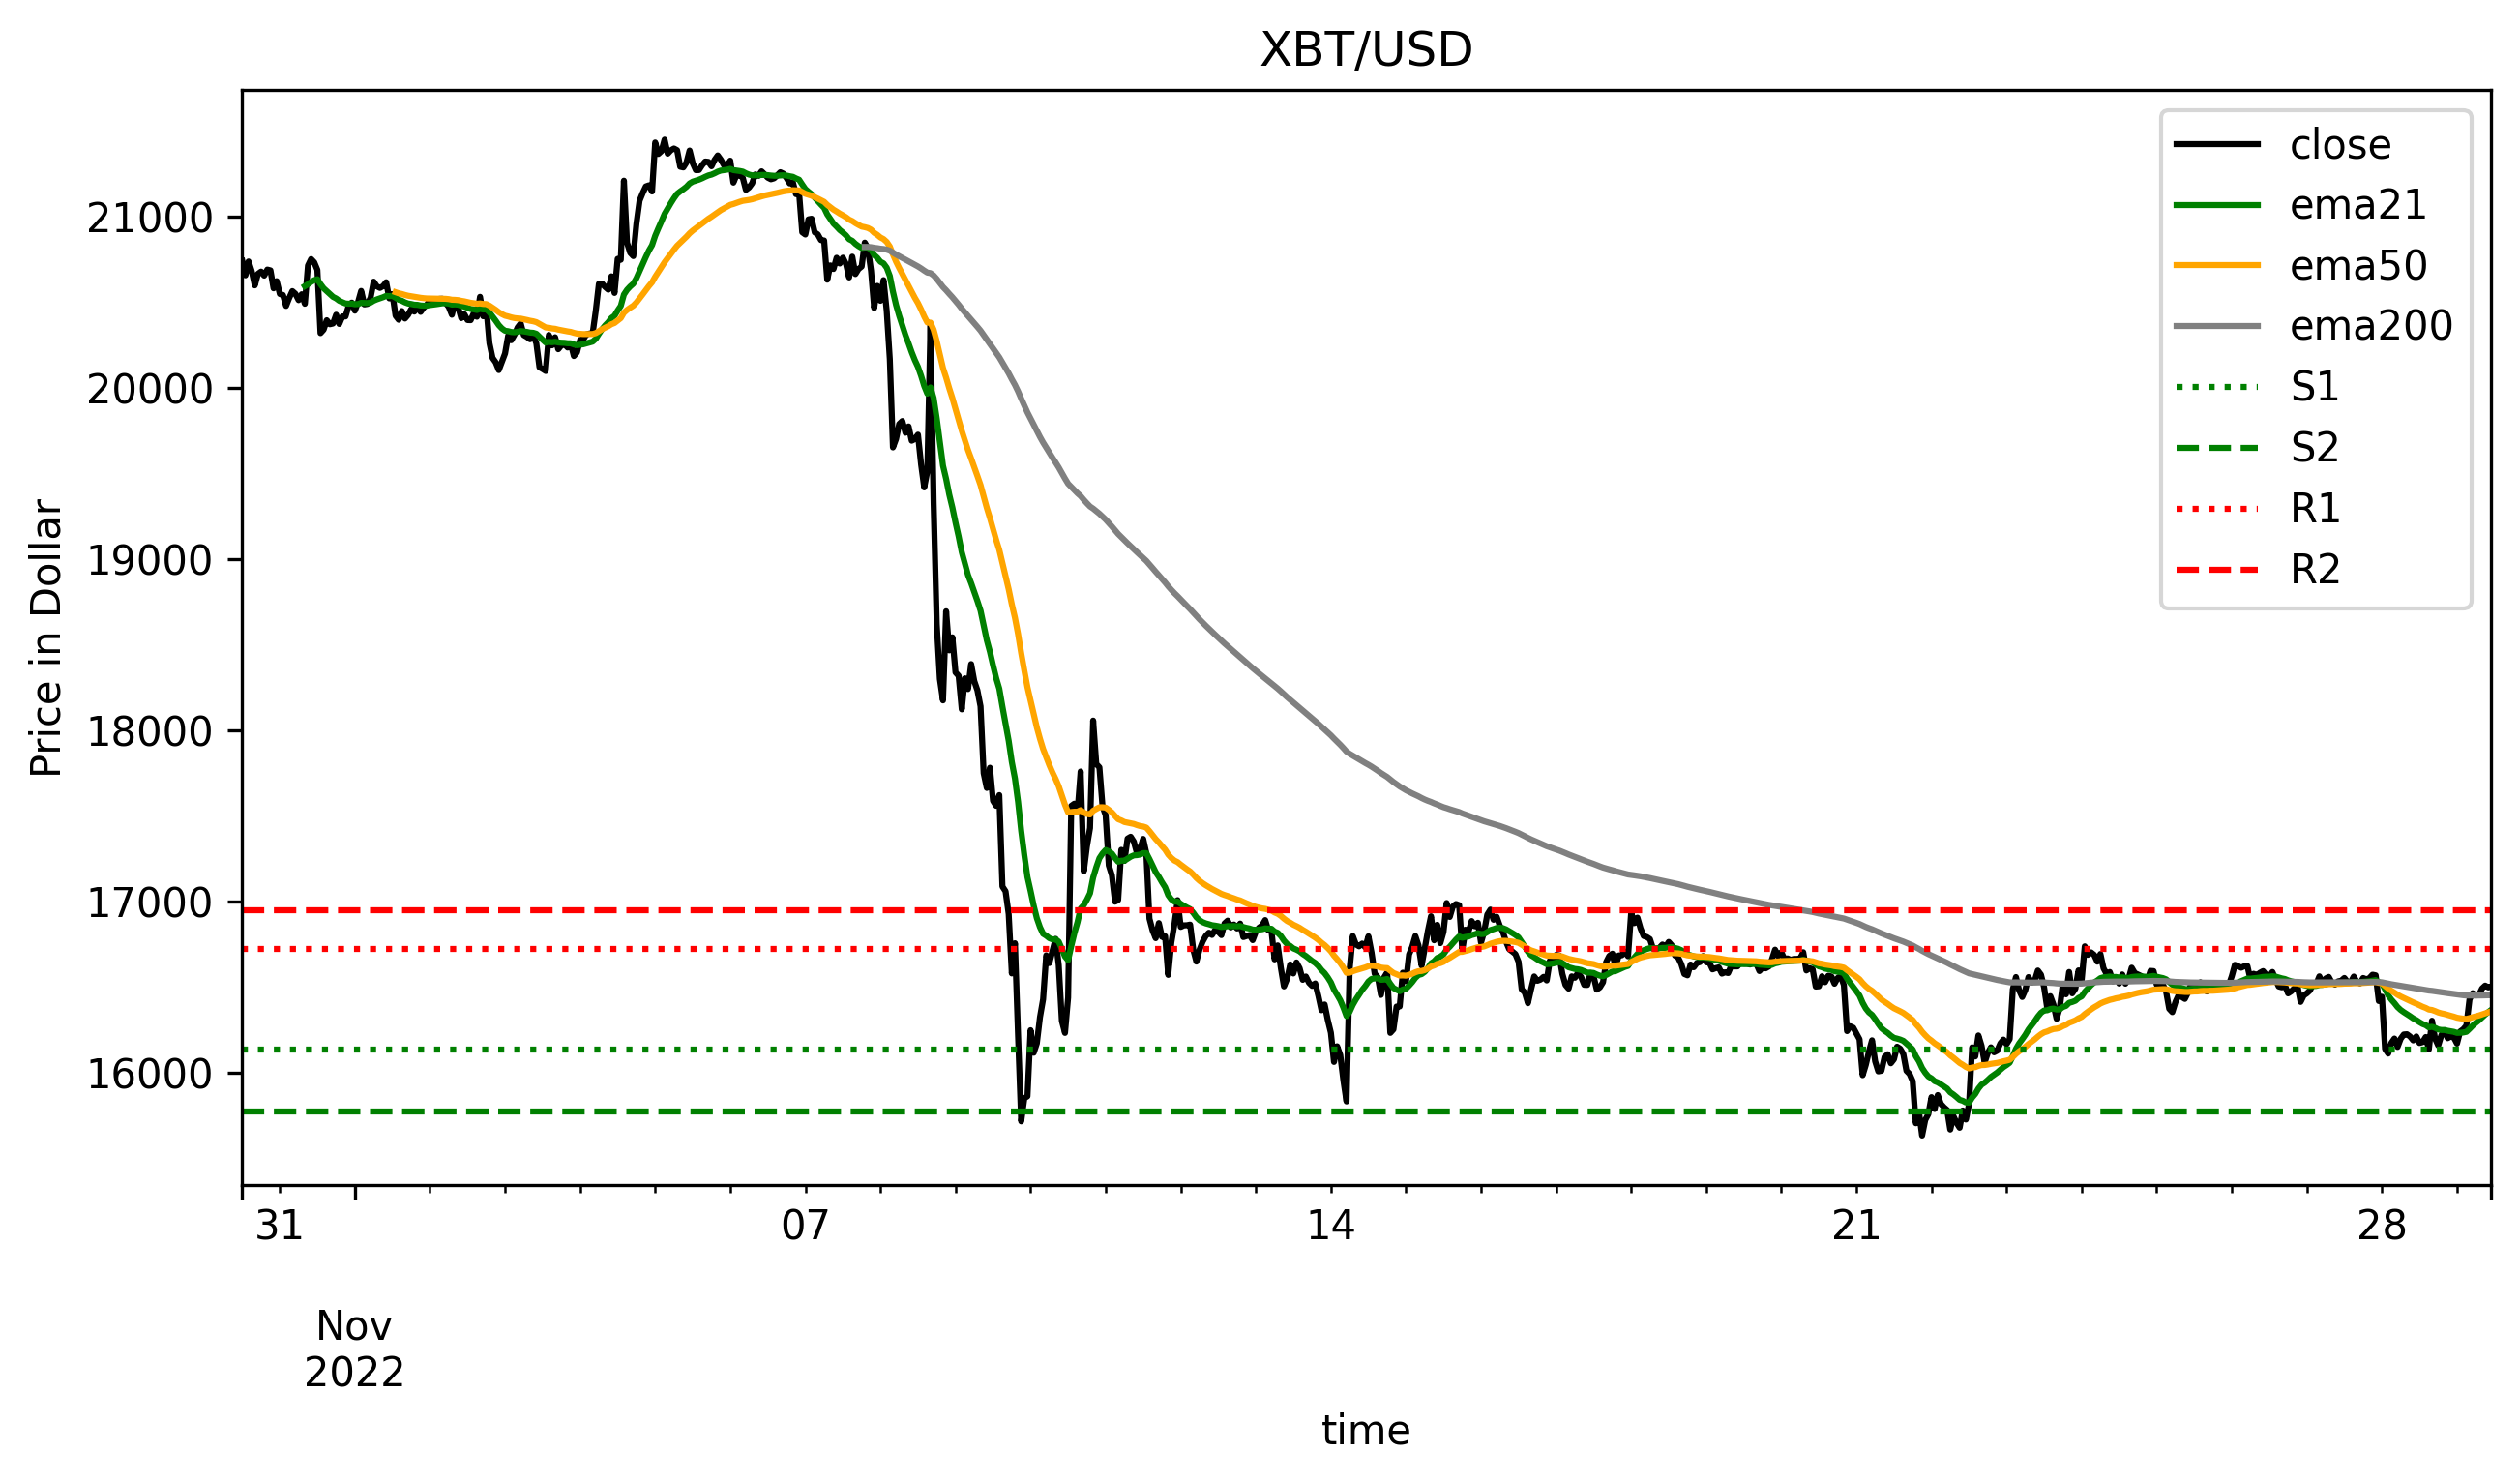

In [8]:
fig = plt.figure(figsize=(10,5), dpi=300)
ax = plt.gca()
df.plot(x='time', y=['close', 'ema21', 'ema50', 'ema200'], ax=ax, color=['black', 'green', 'orange', 'gray'])

xmin, xmax = df['time'].iloc[0], df['time'].iloc[-1]
ax.hlines(y=df['s1'].iloc[-1], xmin=xmin, xmax=xmax, color='green', linestyle=':', label='S1')
ax.hlines(y=df['s2'].iloc[-1], xmin=xmin, xmax=xmax, color='green', linestyle='--', label='S2')
ax.hlines(y=df['r1'].iloc[-1], xmin=xmin, xmax=xmax, color='red', linestyle=':', label='R1')
ax.hlines(y=df['r2'].iloc[-1], xmin=xmin, xmax=xmax, color='red', linestyle='--', label='R2')
ax.set_ylabel('Price in Dollar')
plt.legend()
plt.title('XBT/USD');

### Create and combine custom indicators, implement them, and build your own strategies ...